In [1]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [2]:
rootfolder = '.'

Useful function for plot the 2D DCT dictionary

In [3]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [4]:
def OMP(s, D, L, tau):
    M, N = D.shape
    x = np.zeros(N)
    
    r = s.copy()
    
    omega = []
    
    while np.count_nonzero(x) < L and np.linalg.norm(r) > tau:
        
        e = np.zeros(N)
        for j in range(N):
            e[j] = np.linalg.norm(r, 2)**2 - (r.T @ D[:,j])**2 / np.linalg.norm(D[:, j], 2)**2

        # find the column of D that matches at best r
        jStar = np.argmin(e)

        # UPDATE the support set with the jStar coefficient
        if jStar not in omega:
            omega.append(jStar)

        # update the coefficients by solving the least square problem min ||D_omega x - s ||
        x[omega] = np.linalg.inv((D[:, omega].T @ D[:, omega])) @ D[:, omega].T @ s

        # update the residual
        r = s - D @ x

    return x

Load the image and rescale it in $[0,1]$

In [5]:
# img = imread(f'{rootfolder}/data/cameraman.png') / 255
img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


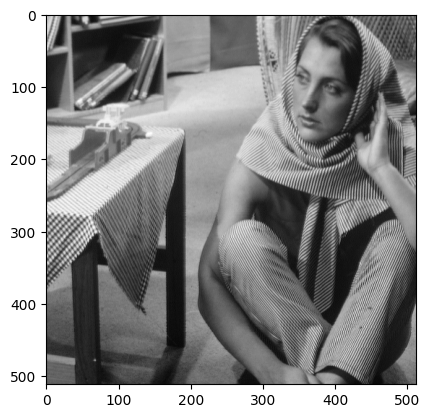

In [6]:
# Plot img
plt.figure()
plt.imshow(img, cmap='gray')

Extract a bunch of random patches from the image

In [7]:
npatch = 10000 # 10000

S = np.zeros((M, npatch))

for i in range(npatch):
    x = np.random.randint(0, imsz[0] - p)
    y = np.random.randint(0, imsz[1] - p)
    patch = img[x:x+p, y:y+p].flatten()
    S[:, i] = patch

Remove the mean from the patches (each column of $S$ must have zero-mean)

In [8]:
S -= S.mean(axis=0)

Initialize the dictionary and the coefficient matrix

In [9]:
# number of columns of the dictionary
N = 256 # 256

# intialize the dictionary
D = np.random.randn(M, N)

print(D.shape)

# normalize each column of D (zero mean and unit norm)
# UPDATE D
D -= D.mean(axis=0)
D /= np.linalg.norm(D, axis=0, ord=2)

# number of iteration of the KSVD
max_iter = 10

# maximum number of nonzero coefficients for the sparse coding
L = 4

# initialize the coefficient matrix
X = np.zeros((N, npatch))


(64, 256)


Main KSVD loop


In [10]:
for iter in range(max_iter):
    time_start = time.time()
    print(f'iter {iter}')
    # perform the sparse coding via OMP of all the columns of S
    for n in range(npatch):
        X[:, n] = OMP(S[:, n], D, L, 0)
    
    # iterate over the columns of D
    for j in range(N):
        # find which signals uses the j-th atom in the sparse coding
        omega = np.where(X[j, :] != 0)[0] # find the index of the non zero elements

        if len(omega) == 0:
            # if the atom is never used then ignore or substitute it with a random vector
            pass       
        else:
            # compute the residual matrix E, ignoring the j-th atom
            not_j = list(set(range(N)) - {j}) 

            D_not_j = D[:, not_j]
            X_not_j = X[not_j, :]

            E = S - D_not_j @ X_not_j


            # restrict E to the columns indicated by omega
            Eomega = E[:, omega]

            # compute the SVD of Eomega
            U, Sigma, V = np.linalg.svd(Eomega, full_matrices=False)

            # update the dictionary
            D[:, j] = U[:, 0]

            # update the coefficient matrix
            X[j, omega] = Sigma[0] * V[0, :]    

    time_end = time.time()
    print(f'{time_end - time_start:.0f}')


iter 0


248
iter 1
237
iter 2
252
iter 3
19606
iter 4
133
iter 5
143
iter 6
133
iter 7
132
iter 8
131
iter 9
124


Show the learned dictionary

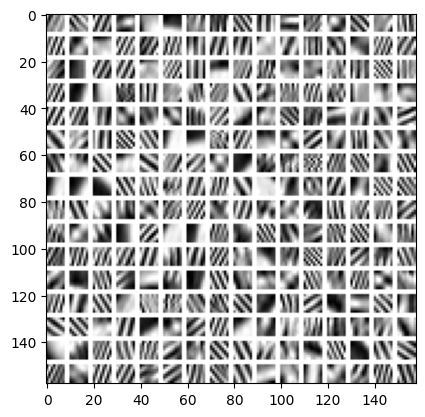

In [11]:
img_dict = get_dictionary_img(D)
plt.figure()
plt.imshow(img_dict, cmap='gray')
